In [3]:
import cv2
import mediapipe as mp
import numpy as np
from scipy.spatial import distance
import speech_recognition as sr
import threading
import time
import psutil
import seaborn as sns
import matplotlib.pyplot as plt
import csv #edit

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Blink Detection Parameters
EYE_AR_THRESH = 0.25
EYE_AR_CONSEC_FRAMES = 3
blink_counter = 0
blink_total = 0
cheat_intensity = 0
voice_detected = False  # To track voice detection

# Iris and Eye Landmarks
LEFT_EYE = [362, 385, 387, 263, 373, 380]
RIGHT_EYE = [33, 160, 158, 133, 153, 144]
LEFT_IRIS = [474, 475, 476, 477]
RIGHT_IRIS = [469, 470, 471, 472]

# Lip Landmarks
UPPER_LIP_INDEX = 13
LOWER_LIP_INDEX = 14
lip_open_count = 0
lip_open = False

# Lists to collect performance data
cpu_usage_data = []
memory_usage_data = []
fps_data = []

# Lists to collect event data
blink_data = []
voice_data = []
lip_open_data = []
gaze_data = []

# EAR Calculation Function
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

# Extract Eye Landmarks from Face Mesh
def extract_eye_landmarks(landmarks, indices):
    return np.array([(landmarks[i].x, landmarks[i].y) for i in indices])

# Voice Detection Function
def detect_voice():
    global voice_detected
    recognizer = sr.Recognizer()
    mic = sr.Microphone()

    with mic as source:
        recognizer.adjust_for_ambient_noise(source)
        while True:
            try:
                audio = recognizer.listen(source, timeout=2, phrase_time_limit=2)
                recognizer.recognize_google(audio)
                voice_detected = True
            except sr.WaitTimeoutError:
                voice_detected = False
            except sr.UnknownValueError:
                voice_detected = False

# Gaze Direction Utility Functions
def get_landmark_coordinates(landmarks, index, image_shape):
    x = int(landmarks[index].x * image_shape[1])
    y = int(landmarks[index].y * image_shape[0])
    return (x, y)

def get_gaze_direction(landmarks, image_shape):
    left_eye = get_landmark_coordinates(landmarks, 33, image_shape)
    right_eye = get_landmark_coordinates(landmarks, 263, image_shape)
    nose_tip = get_landmark_coordinates(landmarks, 1, image_shape)
    
    eye_center = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)
    nose_to_eye_vector = np.array([eye_center[0] - nose_tip[0], eye_center[1] - nose_tip[1]])
    
    if nose_to_eye_vector[0] > 20:
        return "head turned Left"
    elif nose_to_eye_vector[0] < -20:
        return "head turned Right"
    else:
        return "Looking Forward"

# Start voice detection in a separate thread
voice_thread = threading.Thread(target=detect_voice, daemon=True)
voice_thread.start()

# Start webcam feed
cap = cv2.VideoCapture(0)

start_time = time.time()  # Start time for 10-second capture

with mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.4,
    min_tracking_confidence=0.4) as face_mesh:
    frame_data = []
    while cap.isOpened() and (time.time() - start_time) < 10:  # Capture for 10 seconds
        frame_start_time = time.time()  # Start time for frame processing
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            continue

        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        img_h, img_w = image.shape[:2]

        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                mp_drawing.draw_landmarks(
                    image=image,
                    landmark_list=face_landmarks,
                    connections=mp_face_mesh.FACEMESH_TESSELATION,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())

                # Extract eye landmarks
                left_eye = extract_eye_landmarks(face_landmarks.landmark, LEFT_EYE)
                right_eye = extract_eye_landmarks(face_landmarks.landmark, RIGHT_EYE)

                # Calculate EAR for both eyes
                left_eye_ear = eye_aspect_ratio(left_eye)
                right_eye_ear = eye_aspect_ratio(right_eye)
                ear = (left_eye_ear + right_eye_ear) / 2.0

                # Detect blink based on EAR threshold
                if ear < EYE_AR_THRESH:
                    blink_counter += 1
                else:
                    if blink_counter >= EYE_AR_CONSEC_FRAMES:
                        blink_total += 1
                        cheat_intensity += 1
                    blink_counter = 0

                # Display blink count
                cv2.putText(image, f"Blinks: {blink_total}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

                # Detect gaze direction
                gaze_direction = get_gaze_direction(face_landmarks.landmark, image.shape)
                cv2.putText(image, f"Gaze: {gaze_direction}", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

                # Detect lip movement
                upper_lip = face_landmarks.landmark[UPPER_LIP_INDEX]
                lower_lip = face_landmarks.landmark[LOWER_LIP_INDEX]
                lip_distance = abs(upper_lip.y - lower_lip.y)

                if lip_distance > 0.05:
                    if not lip_open:
                        lip_open_count += 1
                        lip_open = True
                else:
                    lip_open = False

                cv2.putText(image, f"Lip Opens: {lip_open_count}", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

                # Detect voice activity
                if voice_detected:
                    cv2.putText(image, "Voice Detected!", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                if lip_open_count >= 3 and voice_detected:
                    cv2.putText(image, "Suspicious Activity Detected!", (10, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                
                #########################
                
                # Calculate and display iris positions
                mesh_points = np.array([np.multiply([p.x, p.y], [img_w, img_h]).astype(int) for p in face_landmarks.landmark])

                (l_cx, l_cy), l_radius = cv2.minEnclosingCircle(mesh_points[LEFT_IRIS])
                center_left = np.array([l_cx, l_cy], dtype=np.int32)
                cv2.circle(image, center_left, int(l_radius), (0, 255, 0), 2, cv2.LINE_AA)

                (r_cx, r_cy), r_radius = cv2.minEnclosingCircle(mesh_points[RIGHT_IRIS])
                center_right = np.array([r_cx, r_cy], dtype=np.int32)
                cv2.circle(image, center_right, int(r_radius), (0, 255, 0), 2, cv2.LINE_AA)

                left_eye_width = np.linalg.norm(left_eye[0] - left_eye[3])
                right_eye_width = np.linalg.norm(right_eye[0] - right_eye[3])

                left_gaze_ratio = (center_left[0] - left_eye[0][0]) / left_eye_width
                right_gaze_ratio = (center_right[0] - right_eye[0][0]) / right_eye_width

                iris_gaze_direction = "Center"
                if left_gaze_ratio < 0.5 and right_gaze_ratio < 0.5:
                    iris_gaze_direction = "Looking Left"
                elif left_gaze_ratio > 0.5 and right_gaze_ratio > 0.5:
                    iris_gaze_direction = "Looking Right"

                cv2.putText(image, f'Iris Gaze: {iris_gaze_direction}', (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                # Append the captured metrics to the lists
                blink_data.append(blink_total)
                voice_data.append(1 if voice_detected else 0)  # 1 if voice is detected, 0 otherwise
                lip_open_data.append(lip_open_count)
                
                # Convert gaze direction into numerical data for plotting
                gaze_direction_map = {"head turned Left": -1, "Looking Forward": 0, "head turned Right": 1}
                gaze_data.append(gaze_direction_map.get(gaze_direction, 0))


                # Collect system data
                cpu_usage_data.append(psutil.cpu_percent())
                memory_usage_data.append(psutil.virtual_memory().percent)
                fps_data.append(1 / (time.time() - frame_start_time))
                ######2
                # Measure CPU and memory usage
                cpu_usage = psutil.cpu_percent()
                memory_usage = psutil.virtual_memory().percent
                frame_end_time = time.time()
                fps = 1 / (frame_end_time - frame_start_time)

                # Store performance metrics
                cpu_usage_data.append(cpu_usage)
                memory_usage_data.append(memory_usage)
                fps_data.append(fps)

                # Display performance metrics
                cv2.putText(image, f"CPU: {cpu_usage:.2f}%", (10, 210), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 255), 2)
                cv2.putText(image, f"Memory: {memory_usage:.2f}%", (10, 240), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 255), 2)
                cv2.putText(image, f"FPS: {fps:.2f}", (10, 270), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 255), 2)

                # Display the image
                cv2.imshow('Gaze, Blink, Voice, Lip, and Iris Detector', image)

                if cv2.waitKey(5) & 0xFF == 27:
                    break
                # Collect data for each frame
                frame_info = {
                    "frame": len(frame_data),
                    "cpu_usage": cpu_usage,
                    "memory_usage": memory_usage,
                    "fps": fps,
                    "blink_total": blink_total,
                    "voice_detected": int(voice_detected),
                    "lip_open_count": lip_open_count,
                    "gaze_direction": gaze_direction_map.get(gaze_direction, 0),
                    "iris_gaze_direction": 1 if iris_gaze_direction == "Looking Right" else -1 if iris_gaze_direction == "Looking Left" else 0,
                    "suspicious": int(lip_open_count >= 3 and voice_detected),  # Example label for suspicious activity
                }

                # Append frame info to frame_data list
                frame_data.append(frame_info)
# Write collected data to a CSV file after the loop ends
csv_file = "suspicious_activity_data.csv"
csv_columns = ["frame", "cpu_usage", "memory_usage", "fps", "blink_total", "voice_detected", "lip_open_count", "gaze_direction", "iris_gaze_direction", "suspicious"]

try:
    with open(csv_file, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for data in frame_data:
            writer.writerow(data)
    print(f"Data saved to {csv_file}")
except IOError:
    print("I/O error occurred while saving CSV")

cap.release()
cv2.destroyAllWindows()



I0000 00:00:1730088346.135428 60540659 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1730088346.138757 60541383 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730088346.148012 60541382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/prathamhandique/Downloads/anaconda3/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Data saved to suspicious_activity_data.csv


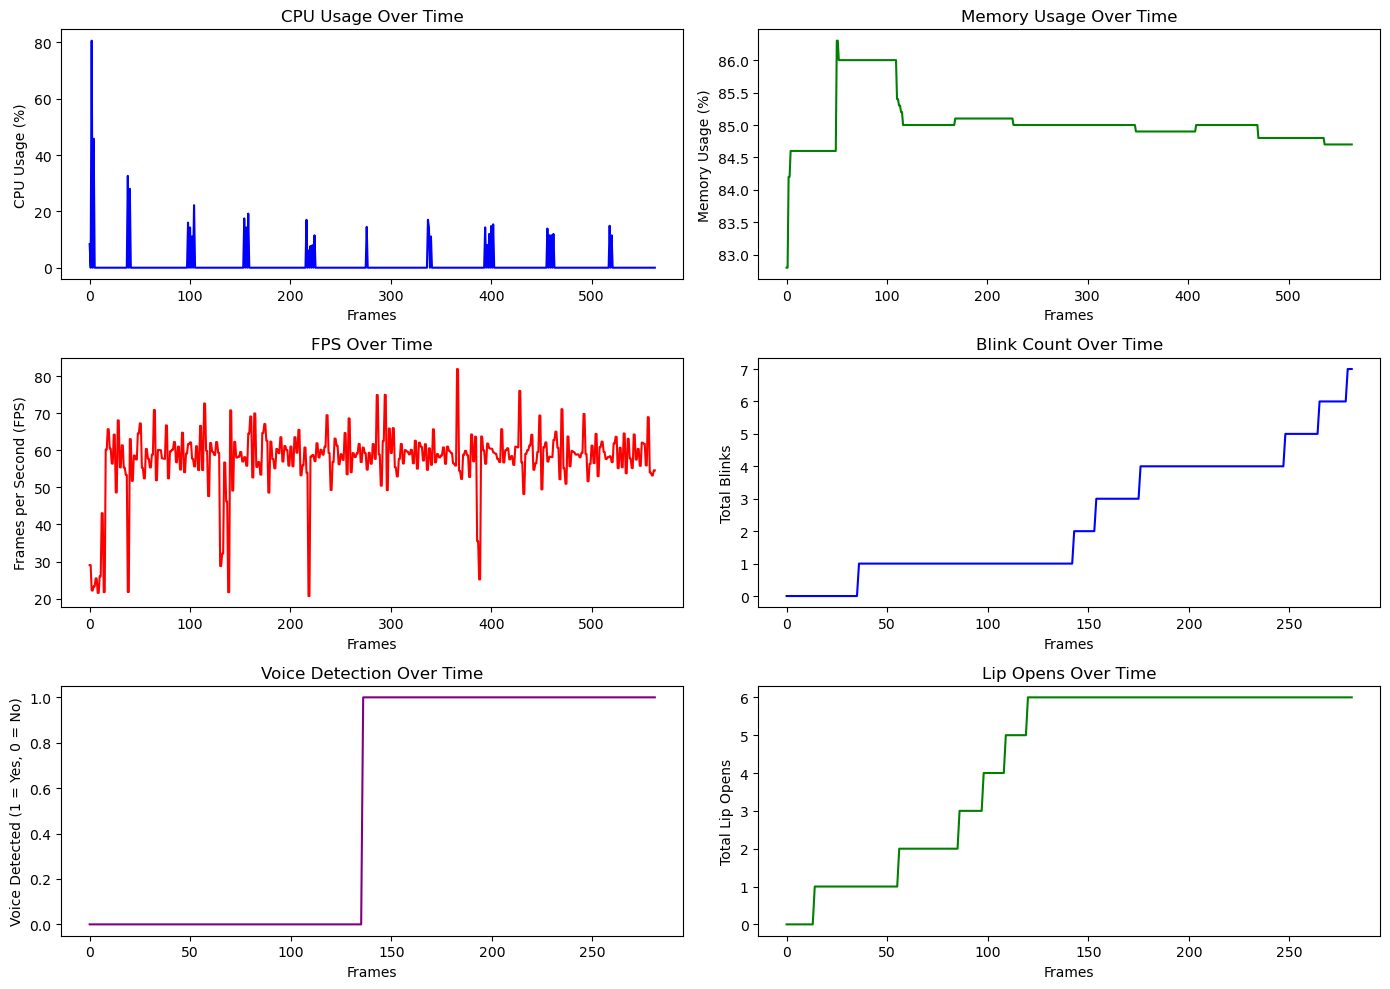

In [4]:
#Plot the performance and event data with Seaborn
plt.figure(figsize=(14, 10))

# CPU Usage Plot
plt.subplot(3, 2, 1)
sns.lineplot(x=range(len(cpu_usage_data)), y=cpu_usage_data, color='blue')
plt.title("CPU Usage Over Time")
plt.xlabel("Frames")
plt.ylabel("CPU Usage (%)")

# Memory Usage Plot
plt.subplot(3, 2, 2)
sns.lineplot(x=range(len(memory_usage_data)), y=memory_usage_data, color='green')
plt.title("Memory Usage Over Time")
plt.xlabel("Frames")
plt.ylabel("Memory Usage (%)")

# FPS Plot
plt.subplot(3, 2, 3)
sns.lineplot(x=range(len(fps_data)), y=fps_data, color='red')
plt.title("FPS Over Time")
plt.xlabel("Frames")
plt.ylabel("Frames per Second (FPS)")

# Blink Count Plot
plt.subplot(3, 2, 4)
sns.lineplot(x=range(len(blink_data)), y=blink_data, color='blue')
plt.title("Blink Count Over Time")
plt.xlabel("Frames")
plt.ylabel("Total Blinks")

# Voice Detection Plot
plt.subplot(3, 2, 5)
sns.lineplot(x=range(len(voice_data)), y=voice_data, color='purple')
plt.title("Voice Detection Over Time")
plt.xlabel("Frames")
plt.ylabel("Voice Detected (1 = Yes, 0 = No)")

# Lip Opens Plot
plt.subplot(3, 2, 6)
sns.lineplot(x=range(len(lip_open_data)), y=lip_open_data, color='green')
plt.title("Lip Opens Over Time")
plt.xlabel("Frames")
plt.ylabel("Total Lip Opens")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import numpy as np
import pandas as pd

In [6]:
df = pd.read_csv('suspicious_activity_data.csv')

In [7]:
df.tail(20)


,frame,cpu_usage,memory_usage,fps,blink_total,voice_detected,lip_open_count,gaze_direction,iris_gaze_direction,suspicious
262,262,0.0,84.8,63.621394,5,1,6,0,1,1
263,263,0.0,84.8,55.169337,5,1,6,0,1,1
264,264,0.0,84.8,60.678848,5,1,6,0,1,1
265,265,0.0,84.8,55.414242,6,1,6,0,1,1
266,266,0.0,84.8,64.515843,6,1,6,0,1,1
267,267,0.0,84.8,53.795198,6,1,6,0,1,1
268,268,0.0,84.7,63.091215,6,1,6,0,1,1
269,269,0.0,84.7,57.770395,6,1,6,0,1,1
270,270,0.0,84.7,55.202738,6,1,6,0,1,1
271,271,0.0,84.7,64.246060,6,1,6,0,1,1


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from tensorflow.keras.utils import to_categorical

# Load data
df = pd.read_csv('suspicious_activity_data.csv')

# Separate features and target
X = df.drop(columns=['suspicious']).values
y = df['suspicious'].values

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape X to fit Conv1D input shape (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# One-hot encode the target
y = to_categorical(y, num_classes=2)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the CNN model
model = Sequential([
    Conv1D(64, kernel_size=2, activation='relu', input_shape=(X.shape[1], 1)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')  # 2 classes: suspicious and non-suspicious
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Predict on new data
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)


Epoch 1/10


/Users/prathamhandique/Downloads/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7645 - loss: 0.6214 - val_accuracy: 1.0000 - val_loss: 0.3783
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.3166 - val_accuracy: 1.0000 - val_loss: 0.1992
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1589 - val_accuracy: 1.0000 - val_loss: 0.0957
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0713 - val_accuracy: 1.0000 - val_loss: 0.0486
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0400 - val_accuracy: 1.0000 - val_loss: 0.0271
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0215 - val_accuracy: 1.0000 - val_loss: 0.0171
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0149 - val_accuracy: 1.0000 - val_loss: 0.0117
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 1.0000 - val_loss: 0.0087
Epoch 9/10
7/7 ━━━